In [1]:
import numpy as np
import pandas as pd
import os
import darts


# from utils import fix_pythonpath_if_working_locally
# fix_pythonpath_if_working_locally()


import torch
import matplotlib.pyplot as plt
%matplotlib inline

from darts import TimeSeries
from darts.models import RNNModel, TCNModel, TransformerModel, NBEATSModel, BlockRNNModel
from darts.metrics import mape, smape, rmse
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries


# Series PreProcessing

Here we are pre-processing the total demand and covariate series in a format that is suitable for modelling using DARTS package


In [2]:
df = pd.read_csv("final_demand_19_yarab.csv")
df["datetime"] = pd.to_datetime(df["datetime"])
df = df.set_index("datetime")

df["total_demand"]=df["total_demand"].interpolate()
df["total_demand"]=df["total_demand"].apply(lambda x: np.round(x, 0))
df["HourlyDryBulbTemperature"]=df["HourlyDryBulbTemperature"].interpolate()
df["HourlyWetBulbTemperature"]=df["HourlyWetBulbTemperature"].interpolate()

demand=TimeSeries.from_dataframe(df,None,"total_demand") #none here means that darts time series will use the index as the time index.
dry_temp=TimeSeries.from_dataframe(df,None,"HourlyDryBulbTemperature")
wet_temp=TimeSeries.from_dataframe(df,None,"HourlyWetBulbTemperature")
holiday=TimeSeries.from_dataframe(df,None,"holiday")
weekday=TimeSeries.from_dataframe(df,None,"weekday")


transformer = Scaler()
series_demand_scaled = transformer.fit_transform(demand)
series_dry_temp_scaled = transformer.fit_transform(dry_temp)
series_wet_temp_scaled = transformer.fit_transform(wet_temp)


# keep the last 20% of both series as validation
val = int(len(series_demand_scaled)*0.2)
train_demand, val_demand = series_demand_scaled[:-val], series_demand_scaled[-val:]


# create month and year covariate series
year_series = datetime_attribute_timeseries(series_demand_scaled, attribute='year', one_hot=False)
year_series = Scaler().fit_transform(year_series)
month_series = datetime_attribute_timeseries(year_series, attribute='month', one_hot=True)

# covariates
series_dry_temp_scaled = transformer.fit_transform(dry_temp)
series_wet_temp_scaled = transformer.fit_transform(wet_temp)
covariates = year_series.stack(month_series).stack(series_dry_temp_scaled).stack(series_wet_temp_scaled)
train_cov, val_cov = covariates[:-val], covariates[-val:]


print(len(train_demand), len(train_cov ))
print(len(val_demand), len(val_cov ))

7009 7009
1752 1752


# Modelling

In [3]:
rnn_model = RNNModel(model="LSTM",input_chunk_length=48, 
                    training_length=100, 
                    n_rnn_layers=3)



In [ ]:
rnn_model.fit(train_demand, 
             future_covariates=train_cov, 
             epochs=50, 
             verbose=True)


In [44]:
tree = RandomForest(24*5,lags_future_covariates=[0]*24*5)



In [49]:
tree.fit(train_demand, 
             future_covariates=train_cov)


# Back testing the models

In [98]:

# this is the backtesting function
def eval_model(model, demandy,horizon=24,past_covariates=None, future_covariates=None):
    # Past and future covariates are optional because they won't always be used in our tests
    
    # We backtest the model on the last 20% of the flow series, with a horizon of 10 steps:
    backtest = model.historical_forecasts(series=demandy, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          start=len(demandy)-24*50, 
                                          retrain=False,
                                          verbose=True, 
                                          forecast_horizon=horizon)
    
    demandy[-len(backtest)-24*30:].plot( )

    backtest.plot(label='prediction')
    print('Backtest RMSE = {}'.format(rmse(demandy, backtest)))
    
    range_values=np.max(demandy["total_demand"].pd_series())-np.min(demandy["total_demand"].pd_series())
    
    print(range_values)
    print("Backtest NRMSE",100*rmse(demandy, backtest)/range_values,"%")
                    
    
    #print('Backtest RMSE = {}'.format(mape(demandy, backtest)))


  0%|          | 0/1177 [00:00<?, ?it/s]

Backtest RMSE = 0.06303295318213645
0.9467494714587739
Backtest NRMSE 6.6578281881703925 %


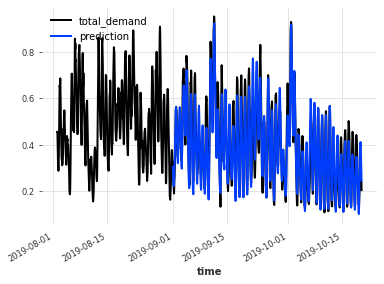

In [99]:

eval_model(rnn_model,train_demand,future_covariates=train_cov)

  0%|          | 0/1177 [00:00<?, ?it/s]

Backtest RMSE = 0.6484026349875471
0.645811310782241
Backtest NRMSE 100.40125097873671 %


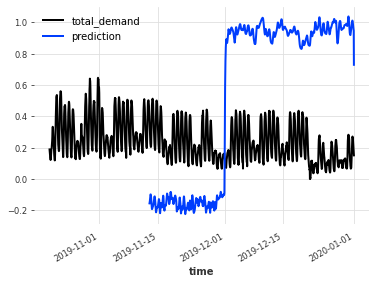

In [100]:
eval_model(rnn_model,val_demand,future_covariates=val_cov)

  0%|          | 0/1177 [00:00<?, ?it/s]

Backtest RMSE = 0.0696854771911349
0.9467494714587739
Backtest NRMSE 7.3604981351362015 %


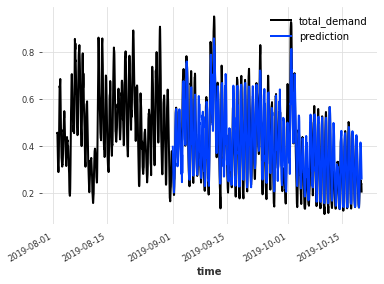

In [101]:
eval_model(tree,train_demand,future_covariates=train_cov)

  0%|          | 0/1177 [00:00<?, ?it/s]

Backtest RMSE = 0.0837393283009447
0.645811310782241
Backtest NRMSE 12.96653169476316 %


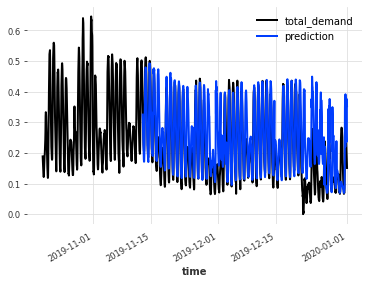

In [102]:
#
eval_model(tree,val_demand,future_covariates=val_cov)

  0%|          | 0/1153 [00:00<?, ?it/s]

Backtest RMSE = 0.10283603266945607
0.645811310782241
Backtest NRMSE 15.923541590638232 %


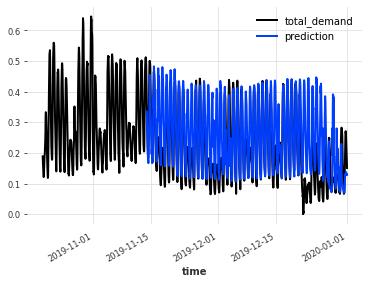

In [103]:
# 48
eval_model(tree,val_demand,future_covariates=val_cov,horizon=48)

  0%|          | 0/1129 [00:00<?, ?it/s]

Backtest RMSE = 0.1075459306976188
0.645811310782241
Backtest NRMSE 16.65284099272796 %


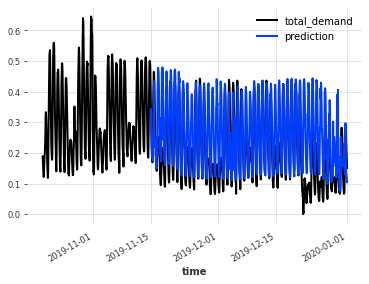

In [104]:
# 48
eval_model(tree,val_demand,future_covariates=val_cov,horizon=72)